<a href="https://colab.research.google.com/github/shadab4150/X_Ray_Covid_19_pnemonia_detection/blob/master/Covid_X_ray_image_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

 99% 1.17G/1.19G [00:04<00:00, 260MB/s]
100% 1.19G/1.19G [00:05<00:00, 251MB/s]


In [0]:
!unzip '/content/coronahack-chest-xraydataset.zip'

In [4]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import matplotlib.image as immg

In [0]:
path = Path('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/')

In [0]:
df = pd.read_csv('/content/Chest_xray_Corona_Metadata.csv')

In [148]:
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,file_name,image_format,valid
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0128-0001,jpeg,False
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0127-0001,jpeg,False
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0125-0001,jpeg,False
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0122-0001,jpeg,False
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,IM-0119-0001,jpeg,False


## Traning and Test has images of multiple format of varying channels
* Here I am coverting them into **'.png'** and **RGB** format.
* Original images are quite big
* Will convert them to 512x512

In [0]:
df.fillna(value='NULL',inplace=True)

In [0]:
name = df.X_ray_image_name.tolist()

In [0]:
df['file_name']= [x.split('.')[0] for x in name]

In [0]:
df['image_format'] = [x.split('.')[-1] for x in name]

In [0]:
jpg_img = df[df['image_format']=='jpg'].copy()
png_img = df[df['image_format']=='png'].copy()
name_jpg = jpg_img.X_ray_image_name.tolist()
name_png = png_img.X_ray_image_name.tolist()

In [0]:
val = df.Dataset_type.tolist()
for i in range(len(val)):
  if val[i]=='TRAIN':
    val[i]=False
  else:
    val[i]=True

In [0]:
df['valid']=val

In [0]:
df.to_csv('covid_xray_format_valid.csv',index=False)

In [158]:
from collections import Counter
extn = Counter([x.split('.')[-1] for x in name]);extn

Counter({'jpeg': 5878, 'jpg': 24, 'png': 8})

## Converting all in small Training images
* **Parallel** function makes use of all available cores, process them in parallel
* Courtsey of **fast.ai**

In [0]:
def image_process(f,index):   # My custom function to process image to jpg and resize to 512x512
  path_hr = path/'train'
  img = PIL.Image.open(path_hr/f)
  img = img.resize((512,512),resample=PIL.Image.BILINEAR).convert('RGB')
  loc = '/content/small_xray/'+str(f.split('.')[0])+'.jpg'
  img.save(loc,quality = 75)

name_tr = df[df['Dataset_type']=='TRAIN'].X_ray_image_name.tolist()
parallel(image_process,name_tr,max_workers=5)

## Converting all in small Testing images

In [137]:
def image_process(f,index):
  path_hr = path/'test'
  img = PIL.Image.open(path_hr/f)
  img = img.resize((512,512),resample=PIL.Image.BILINEAR).convert('RGB')
  loc = '/content/small_xray/'+str(f.split('.')[0])+'.jpg'
  img.save(loc,quality = 75)


name_ts = df[df['Dataset_type']=='TEST'].X_ray_image_name.tolist()
parallel(image_process,name_ts,max_workers=5)

* Zip them to save in drive

In [0]:
import shutil 

In [138]:
shutil.make_archive('XRay_pnemonia_train','zip','/content/small_xray/')

'/content/XRay_pnemonia_train.zip'

In [135]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


* Saving to drive

In [0]:
!cp '/content/XRay_pnemonia_train.zip' '/content/drive/My Drive/Dataset/'

## Creating a DataBunch

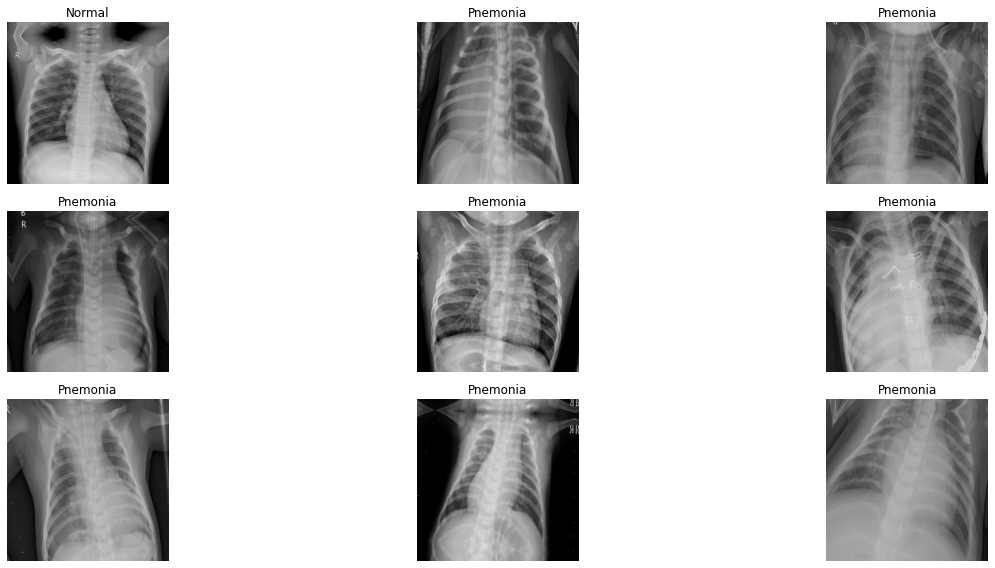

In [156]:
path1 = Path('/content/')
data = (ImageList.from_df(df,path1,folder='small_xray',suffix='.jpg',cols='file_name')
                .split_from_df(col='valid')
                .label_from_df(cols='Label')
                .transform(get_transforms(do_flip=True),size=256)
                .databunch(bs=128)).normalize(imagenet_stats)

data.show_batch(rows=3,figsize=(20,8))

In [157]:
len(data.train_ds),len(data.valid_ds),data.classes

(5286, 624, ['Normal', 'Pnemonia'])

## Now it is ready for a CNN